# Load DICOM data stored in IGT Cloud


The url to the cloud:

In [1]:
igtcloud_domain = 'igt-web.eu1.phsdp.com'
username = None
# username = '<your hsdp iam username>'

Import the igtcloud packages:

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

from igtcloud.client.services import entities_service, auth_service
from igtcloud.client.core.auth import AuthRefresher

Either login using `igtcloud login` or use the following cell

In [3]:
_auth_refresher = AuthRefresher(domain=igtcloud_domain, username=username)
_auth_handler = _auth_refresher.__enter__()
entities_service.auth_handler = _auth_handler
auth_service.auth_handler = _auth_handler

INFO:igtcloud.client.core.auth:Starting IGT Cloud authentication handler...
INFO:igtcloud.client.core.auth:Login to IGT Cloud (igt-web.eu1.phsdp.com)


Username:  danny.ruijters@philips.com
danny.ruijters@philips.com@igt-web.eu1.phsdp.com's password:  ········


INFO:igtcloud.client.core.auth:Logged in as: danny.ruijters@philips.com


List all institutes (hospitals) in your account:

In [4]:
projects = entities_service.get_projects()

import ipywidgets as widgets
select_proj = widgets.Select(
    options=[i.description for i in projects],
    rows=10, layout=widgets.Layout(width="auto"),
    description='Projects:'
)
select_proj

Select(description='Projects:', layout=Layout(width='auto'), options=('New demo', 'Istanbul', 'Robotic Procedu…

In [6]:
project = projects[select_proj.index]
institutes = entities_service.get_institutes(project.id)

select_inst = widgets.Select(
    options=[i.description for i in institutes],
    rows=10, layout=widgets.Layout(width="auto"),
    description='Institutes:'
)
select_inst

Select(description='Institutes:', layout=Layout(width='auto'), options=('Erasmus',), rows=10, value='Erasmus')

Load an overview of the studies for the selected hospitals, and list the patient names:

In [7]:
institute = institutes[select_inst.index]
#print(institute)
studies = entities_service.get_studies(institute.id)

select_pat = widgets.Select(
    options=[s.patient.patient_name for s in studies],
    rows=10, layout=widgets.Layout(width="auto"),
    description='Patients:'
)
select_pat

Select(description='Patients:', layout=Layout(width='auto'), options=('No Name-202404101117127',), rows=10, va…

Display all the thumbnail preview images in the selected patient:

In [8]:
# display the thumbnails
import io
from IPython.display import display

def preview(files):
    images = []
    for file in files[:50]:  #parse first 50 files to keep processing time limited
        if file.type == '.jpg' or file.type == '.png':
            with io.BytesIO() as fp:
                file.download_fileobj(fp)
                fp.seek(0)
                img = widgets.Image(value=fp.read(), format=file.type[1:])
                if len(images) > 0: img.height=images[0].height
                images.append(img)
    display(widgets.HBox(images))

study_id = studies[select_pat.index].study_database_id
study_files = entities_service.get_study_files(institute.id, study_id, auxiliary=True)
if hasattr(study_files, 'dicom'): preview(study_files.dicom)
if hasattr(study_files, 'files'): preview(study_files.files)

HBox()

Select one of the files:

In [9]:
if hasattr(study_files, 'dicom'):
    dicom_files = [file for file in study_files.dicom if file.type == 'unknown']
else:
    dicom_files = [file for file in study_files.files if file.type == 'unknown']
    
select_file1 = widgets.Select(
    options=[f.file_name for f in dicom_files],
    rows=10, layout=widgets.Layout(width="auto"),
    description='Files:'
)
select_file1

Select(description='Files:', layout=Layout(width='auto'), options=('0db7f467d18e36466cb809eaa81c1a98f830de0e/0…

Download the selected file, store as temporary file, and interpret as DICOM:

In [13]:
import tempfile
import pydicom

def LoadDicom(file):
    with tempfile.TemporaryFile() as fp:
        file.download_fileobj(fp)
        fp.seek(0)
        return pydicom.read_file(fp)

dicom1 = LoadDicom(dicom_files[select_file1.index])

View the downloaded DICOM file:

In [11]:
dicom1

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 110
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: X-Ray Angiographic Image Storage
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.46.670589.7.29.0.0.0
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'SINGLE PLANE']
(0008, 0016) SOP Class UID                       UI: X-Ray Angiographic Image Storage
(0008, 0018) SOP Instance UID                    UI: 2.25.147197726452889623620227255215142970862.1879404410
(0008, 0020) Study Date                          DA: '20240410'
(0008, 0021) Series Date                         DA: '20240410'
(0008, 0023) Content Date                        DA: 

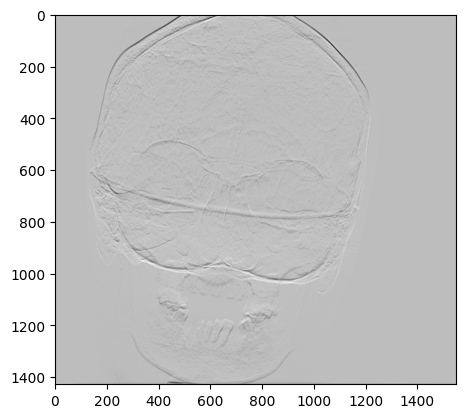

In [14]:
from matplotlib import pyplot, cm
from ipywidgets import interact, widgets

if hasattr(dicom1, 'pixel_array'):
    if hasattr(dicom1, 'NumberOfFrames') and dicom1.NumberOfFrames > 1:
        def dicom_animation2(n):
            pyplot.imshow(dicom1.pixel_array[n], cmap='gray')
            return n

        interact(dicom_animation2, n=(0, len(dicom1.pixel_array)-1))
    else:
        pyplot.imshow(dicom1.pixel_array, cmap='gray')